In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline

# Final Project

# Data Acquisition
The following code imports and validates the LendingClub data.

In [12]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [169]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

if 0:
    #ignore this - was trying to pickle the data into
    #formats like feather, hdf5, native python pickling, etc
    # but found issues on python 3.7
    df=pd.read_pickle(basepath+'df.pkl')
else:
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,low_memory=False,)
        df=df.append(tdf)
    df.reset_index(inplace=True) # This will help with joining back data if necessary.

print(df.shape)

Reading ./Source Data/Loan Data/LoanStats3a_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3b_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3c_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3d_securev1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2018Q1.csv


ImportError: the feather-format library is not installed
you can install via conda
conda install feather-format -c conda-forge
or via pip
pip install -U feather-format


In [14]:
pd.set_option('display.max_rows', 160)
print(df.dtypes)
pd.set_option('display.max_rows', 20)

index                                           int64
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                  

In [15]:
# Checks for duplicates within our combined data
df['count']=1 # Generate field to measure the number of occurances

counts = df.groupby('id')['count'].count()
print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.


Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [175]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
#print(len(has_data))
#has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=150
for i,j in zip(order_has_data[0:top_sparse-1],range(top_sparse)):
    print(j, i, has_data[i])

0 member_id 0
1 orig_projected_additional_accrued_interest 5846
2 hardship_type 7288
3 hardship_reason 7288
4 hardship_status 7288
5 deferral_term 7288
6 hardship_amount 7288
7 hardship_start_date 7288
8 hardship_end_date 7288
9 payment_plan_start_date 7288
10 hardship_length 7288
11 hardship_dpd 7288
12 hardship_loan_status 7288
13 hardship_payoff_balance_amount 7288
14 hardship_last_payment_amount 7288
15 sec_app_mths_since_last_major_derog 18992
16 debt_settlement_flag_date 21652
17 settlement_status 21652
18 settlement_date 21652
19 settlement_amount 21652
20 settlement_percentage 21652
21 settlement_term 21652
22 sec_app_revol_util 54417
23 revol_bal_joint 55366
24 sec_app_fico_range_low 55367
25 sec_app_fico_range_high 55367
26 sec_app_earliest_cr_line 55367
27 sec_app_inq_last_6mths 55367
28 sec_app_mort_acc 55367
29 sec_app_open_acc 55367
30 sec_app_open_act_il 55367
31 sec_app_num_rev_accts 55367
32 sec_app_chargeoff_within_12_mths 55367
33 sec_app_collections_12_mths_ex_med 5

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

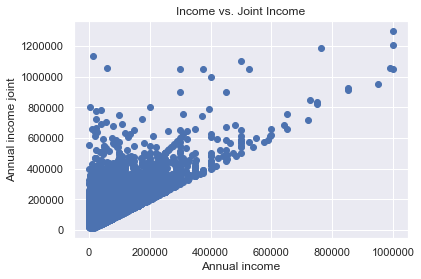

In [17]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;

Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [123]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data
# Convert the loan issue date to a datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
#determine age of credit line prior to load and convert to integer
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days
# convert to year to consider economic conditions
df['issue_d'] = df['issue_d'].dt.year

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high',
],inplace=True)
print(reduced_df.shape)

(1020552, 69)


In [125]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)


print(reduced_df.shape)

(1020552, 69)


In [128]:
backup_df=pd.DataFrame.copy(reduced_df)
print(backup_df.shape)

(1020552, 69)


In [73]:
reduced_df=pd.DataFrame.copy(backup_df)
print(reduced_df.shape)

(1020552, 68)


# Which variables are categorical?

In [131]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:50]:
    print(i, n_options[i],reduced_df[i].unique())


out_prncp 1 [0.]
out_prncp_inv 1 [0.]
application_type 2 ['Individual' 'Joint App']
term 2 [' 36 months' ' 60 months']
verification_status 3 ['Verified' 'Source Verified' 'Not Verified']
home_ownership 6 ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
inq_last_6mths 10 [ 1.  5.  2.  0.  3.  4.  6.  7.  8. nan]
chargeoff_within_12_mths 11 [ 0. nan  1.  2.  3.  4.  5.  7.  6. 10.  8.]
emp_length 12 [10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7. nan]
pub_rec_bankruptcies 13 [ 0.  1.  2. nan  4.  3.  8.  5.  6.  7. 12.  9. 11.]
purpose 14 ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
collections_12_mths_ex_med 15 [ 0. nan  1.  2.  4.  3.  6. 16. 20.  5. 10. 14.  7. 12.  9.]
open_il_12m 19 [nan  0.  2.  1.  3.  4.  6.  5.  9.  7.  8. 10. 12. 11. 13. 14. 20. 21.
 25.]
open_acc_6m 20 [nan  0.  2.  3.  6.  1.  4.  5.  9.  7.  8. 10. 14. 12. 11. 16. 15. 18.
 

mths_since_last_major_derog 166 [ nan  53.  34.  69.  71.  54.   7.  16.  33.  45.  59.  11.   8.  56.
  50.  32.  76.  70.  39.  49.  64.  62.  74.  52.  46.  60.  51.  77.
  27.  72.  22.  48.  58.  10.  73.  23.  61.  35.  57.  40.  18.  25.
  63.  21.  47.  41.  80.  68.  44.  31.  28.  65.  30.  13.  15.  75.
  26.  67.  12.  81.   5.  14.   6.  19.  43.  29.  42.  37.  38.  17.
   4.  24.   9.  79.  66.  20.  36. 110.   1.  84.  78.  55.   2.   3.
  82. 135. 152.  92. 115.  88.  95. 100. 123. 106.  83. 102.  94.  87.
  85. 122.  89.   0. 109.  86.  91. 146. 134. 114.  99.  97.  93.  96.
  90. 165. 127. 119. 101. 124. 129. 113. 120. 139. 131. 112. 156. 143.
 149. 118. 130. 104. 111. 148. 126. 141. 116. 133. 108.  98. 107. 147.
 121. 154. 105. 103. 162. 140. 170. 136. 180. 188. 151. 159. 137. 117.
 171. 142. 125. 132. 153. 145. 176. 150. 158. 197. 192. 160.]
mo_sin_rcnt_tl 178 [ nan   1.   2.  13.   7.   3.   0.   8.   4.   6.  25.  17.  14.   9.
  12.  11.  24.   5.  27.  16.  30.

Based on these results, we will have to encode several terms as dummy variables:
- 'application_type'
- 'term'
- 'verification_status'
- 'home_ownership'
- 'purpose'


In [132]:
seta=set(reduced_df.columns)

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status',
                                                   'home_ownership','purpose'],
                          drop_first=True)


setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'purpose_debt_consolidation', 'purpose_house', 'purpose_renewable_energy', 'home_ownership_NONE', 'purpose_small_business', 'purpose_moving', 'home_ownership_MORTGAGE', 'purpose_credit_card', 'verification_status_Source Verified', 'purpose_wedding', 'purpose_educational', 'purpose_medical', 'term_ 60 months', 'purpose_home_improvement', 'purpose_vacation', 'application_type_Joint App', 'verification_status_Verified', 'home_ownership_OTHER', 'purpose_other', 'purpose_major_purchase', 'home_ownership_RENT', 'home_ownership_OWN'}
(1020552, 86)


# How to treat NaN

For now, let's remove majority NaN columns...

In [133]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=20
for i,j in zip(order_has_data[0:top_sparse-1],range(top_sparse)):
    print(j, i, has_data[i])

0 mths_since_last_record 172185
1 mths_since_recent_bc_dlq 240759
2 mths_since_last_major_derog 264308
3 mths_since_rcnt_il 289098
4 all_util 296067
5 inq_last_12m 296092
6 open_acc_6m 296092
7 total_cu_tl 296092
8 inq_fi 296093
9 open_il_12m 296093
10 open_il_24m 296093
11 open_rv_12m 296093
12 open_rv_24m 296093
13 mths_since_recent_revol_delinq 338379
14 mths_since_last_delinq 503506
15 mths_since_recent_inq 881746
16 mo_sin_old_il_acct 924972
17 pct_tl_nvr_dlq 952881
18 mo_sin_old_rev_tl_op 953024


In [157]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:16])
print(nonnan_df.shape)

(1020552, 70)


In [158]:
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:14]:
    print(i, n_options[i],nonnan_df[i].unique())

6889 866126
(866126, 70)
out_prncp 1 [0.]
out_prncp_inv 1 [0.]
application_type_Joint App 2 [0 1]
term_ 60 months 2 [1 0]
verification_status_Source Verified 2 [0 1]
verification_status_Verified 2 [1 0]
home_ownership_MORTGAGE 2 [0 1]
home_ownership_NONE 2 [0 1]
home_ownership_OTHER 2 [0 1]
home_ownership_OWN 2 [0 1]
home_ownership_RENT 2 [1 0]
purpose_credit_card 2 [0 1]
purpose_debt_consolidation 2 [1 0]
purpose_educational 2 [0 1]


In [136]:
nonnan_df.dtypes

acc_open_past_24mths          float64
annual_inc                    float64
bc_open_to_buy                float64
chargeoff_within_12_mths      float64
collection_recovery_fee       float64
collections_12_mths_ex_med    float64
delinq_2yrs                   float64
dti                           float64
earliest_cr_line              float64
emp_length                    float64
                               ...   
purpose_home_improvement        uint8
purpose_house                   uint8
purpose_major_purchase          uint8
purpose_medical                 uint8
purpose_moving                  uint8
purpose_other                   uint8
purpose_renewable_energy        uint8
purpose_small_business          uint8
purpose_vacation                uint8
purpose_wedding                 uint8
Length: 70, dtype: object

# What factors are correlated?

Factors with high correlation (> 0.7) are:
	 0 acc_open_past_24mths vs num_tl_op_past_12m = 0.7509788943659462
	 1 bc_open_to_buy vs total_bc_limit = 0.8324062426932592
	 2 earliest_cr_line vs mo_sin_old_rev_tl_op = 0.9157759258193829
	 3 installment vs loan_amnt = 0.95230907408298
	 4 installment vs total_pymnt = 0.807206435090318
	 5 loan_amnt vs installment = 0.9523090740829803
	 6 loan_amnt vs total_pymnt = 0.8446305251400827
	 7 mo_sin_old_rev_tl_op vs earliest_cr_line = 0.9157759258193829
	 8 num_bc_sats vs num_bc_tl = 0.700494226786892
	 9 num_bc_sats vs num_op_rev_tl = 0.7312004184557898
	 10 num_bc_tl vs num_bc_sats = 0.700494226786892
	 11 num_bc_tl vs num_rev_accts = 0.838936646458377
	 12 num_op_rev_tl vs num_bc_sats = 0.7312004184557898
	 13 num_op_rev_tl vs num_rev_accts = 0.7656418424320945
	 14 num_op_rev_tl vs num_rev_tl_bal_gt_0 = 0.7892726360425307
	 15 num_op_rev_tl vs num_sats = 0.8245740827506717
	 16 num_op_rev_tl vs open_acc = 0.825531778230132
	 17 num_rev_acct

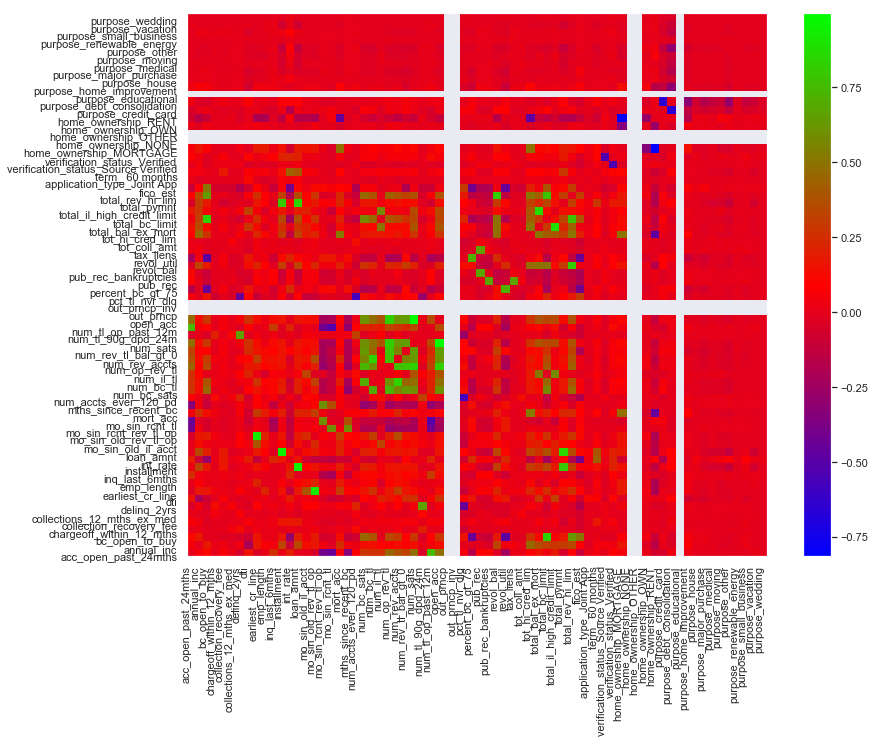

In [153]:
# your code here
# remove the self-correlation value of 1 by subtracting identity matrix

matrix=np.zeros(len(nonnan_df.columns))
for i in range(10):
    small_df=nonnan_df.iloc[np.random.choice(len(nonnan_df), len(nonnan_df)//100, replace=False)]
    temp_matrix=np.corrcoef(small_df,rowvar=False)-np.eye(len(small_df.columns))
    matrix=matrix+temp_matrix

matrix=matrix/10
#print(matrix)
i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> 0.7) are:")
for k in range(len(i)):
    print("\t",k,nonnan_df.columns[i[k]],"vs",nonnan_df.columns[j[k]],"=",matrix[i[k]][j[k]])

plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(nonnan_df.columns)), nonnan_df.columns,rotation='vertical')
plt.yticks(range(len(nonnan_df.columns)), nonnan_df.columns)
plt.colorbar(cmap='brg')
plt.show()

# Let's work with training and test sets
IMPORTANT: NEED TO SCALE DATA STILL

In [159]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
nonnan_df=nonnan_df.drop(columns=['total_pymnt','loan_amnt'])

X_train, X_test, y_train, y_test = train_test_split(
    nonnan_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(1873317, 152) (866126, 70)
(692900, 68) (173226, 68)


In [160]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

0.8775745137203315
[-7.23851070e-03 -1.14365854e-08 -1.40875130e-07 -3.46242683e-03
 -6.94081875e-04 -1.69549167e-02 -8.19082067e-03 -1.95562175e-03
 -6.89863696e-06  7.79255806e-04  1.40463626e-03  9.77807997e-06
  8.10590738e-04  6.50097306e-05  2.05045860e-04 -2.89334029e-04
  1.72205045e-04  5.63270687e-03  1.28033284e-04 -3.07015535e-03
 -6.25788086e-03  4.55831565e-03  3.90973532e-04  2.59242189e-03
 -9.78003652e-04  5.17295107e-04  3.13900476e-03  5.19214655e-03
 -2.10541724e-03 -2.68112930e-03  2.23570735e-16  3.75972876e-16
 -5.06178839e-04 -1.43410158e-05 -4.94586829e-04 -4.85954104e-03
  1.13319073e-07  4.40565142e-04 -1.32960598e-03  1.23874387e-08
 -1.01193775e-10 -1.40271901e-07 -3.24682613e-08  2.24139210e-07
  1.12021044e-09  1.61756429e-04 -6.69736369e-02 -3.05054876e-02
 -1.43805451e-02  4.33243605e-03  1.17791725e-01  2.43751384e-01
  1.58733291e-01  1.01448284e-01  9.37900258e-02  8.03241220e-03
  5.36682326e-03 -1.29353668e-16 -7.37084467e-03 -9.64177547e-04
 -1.43

In [161]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 1
intercept = 0.8835990706753167
betas = [-7.23861643e-03 -1.14363034e-08 -1.40818311e-07 -3.46332366e-03
 -6.94081849e-04 -1.69544992e-02 -8.19075215e-03 -1.95560714e-03
 -6.89875040e-06  7.79285288e-04  1.40493927e-03  9.77865718e-06
  8.10512354e-04  6.50122269e-05  2.05049651e-04 -2.89341347e-04
  1.72195519e-04  5.63275209e-03  1.28042896e-04 -3.07022984e-03
 -6.25803018e-03  4.55858264e-03  3.90944344e-04  2.59249646e-03
 -9.78171230e-04  5.17340269e-04  3.13870471e-03  5.19223861e-03
 -2.10530601e-03 -2.68077731e-03  0.00000000e+00  0.00000000e+00
 -5.06198523e-04 -1.43260063e-05 -4.94805940e-04 -4.85971108e-03
  1.13328731e-07  4.40575369e-04 -1.33100266e-03  1.23876442e-08
 -1.04012117e-10 -1.40268016e-07 -3.25173295e-08  2.24130976e-07
  1.11787012e-09  1.61753947e-04 -6.69605240e-02 -3.05053215e-02
 -1.43809469e-02  4.33287703e-03  1.11765417e-01  2.31119320e-01
  1.48686615e-01  9.54208847e-02  8.77635736e-02  8.03820787e-03
  5.37099204e-03  0.

In [163]:
# your code here

LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 0.9428800328229885
betas = [-7.10960298e-03 -2.14592060e-08 -1.69363834e-07 -0.00000000e+00
 -6.96534966e-04 -0.00000000e+00 -4.12230577e-03 -1.92623862e-03
 -7.01609085e-06  8.53891953e-04  6.24840386e-04  1.49661896e-05
 -0.00000000e+00  6.58459031e-05  2.01974430e-04 -2.77904442e-04
  1.61358687e-04  5.43109518e-03  1.24918010e-04 -1.45706250e-03
 -4.93834223e-03  3.77011085e-03  2.61599615e-04  1.64612041e-03
 -4.73942224e-04  5.61726566e-04  5.56953385e-04 -0.00000000e+00
 -1.05307603e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.65012712e-04  1.65588769e-05 -0.00000000e+00 -0.00000000e+00
  8.31571032e-08  5.13510796e-04 -0.00000000e+00  1.01634884e-08
  7.00049949e-09 -1.05950952e-07 -2.40491552e-08  1.69141251e-07
 -5.75074583e-09  1.81526943e-04 -0.00000000e+00 -2.06753555e-02
 -1.30708753e-02  0.00000000e+00  1.29252151e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.08599751e-03  0.00000000e+00
  4.16046408e-04

## Code for cleanup in the future

In [ ]:
order=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i in order:
    print(i, has_data[i])

# Heat map Visualizations

In [88]:
#Explore the loan status versus purpose

purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]],normalize='index').style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),NMCP Charged Off,NMCP Fully Paid
purpose,,,,,,,,,
car,0.0794803,0.437264,0,0.465604,0.004658,0.00171611,0.00813925,0.000637411,0.00250061
credit_card,0.0937643,0.448954,1.69145e-05,0.439946,0.00604814,0.0019645,0.00848383,0.000166729,0.000654833
debt_consolidation,0.120753,0.418756,9.3169e-06,0.438143,0.00785508,0.00257706,0.0108821,0.000272054,0.000752806
educational,0.132075,0.00235849,0,0.636792,0,0,0,0.0754717,0.153302
home_improvement,0.0933633,0.46286,2.39332e-05,0.422875,0.00685287,0.00235343,0.00996418,0.000566419,0.00114081
house,0.105882,0.46981,0,0.395916,0.00855615,0.00330579,0.0122509,0.00106952,0.00320856
major_purchase,0.0962655,0.457112,0,0.423834,0.0061608,0.00256898,0.0111323,0.000547098,0.00237869
medical,0.112014,0.480094,0,0.383059,0.00746763,0.00304892,0.0117538,0.000972118,0.00159074
moving,0.131589,0.419243,7.67283e-05,0.420931,0.00905394,0.00291568,0.0126602,0.00115092,0.00237858


In [95]:
# Explore the loan status versus loan grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_grade[0]], df[loan_grade[1]],normalize='columns').style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,0.0333653,0.0721829,0.116846,0.175964,0.246851,0.311827,0.316972
Current,0.464073,0.454557,0.454654,0.389097,0.326405,0.26667,0.288298
Default,0,9.0143e-06,2.53646e-05,7.38675e-06,1.66152e-05,2.54408e-05,0
Fully Paid,0.495948,0.458594,0.403087,0.401957,0.387474,0.376371,0.325497
In Grace Period,0.00235661,0.00528058,0.00888124,0.0108364,0.0120211,0.0119317,0.0161888
Late (16-30 days),0.000776295,0.00173615,0.00290244,0.003734,0.00431994,0.00473198,0.00585551
Late (31-120 days),0.00317911,0.00700231,0.0124649,0.015852,0.0184594,0.0221589,0.0304831
NMCP Charged Off,2.46443e-05,0.000153243,0.00026814,0.000727595,0.0013126,0.00236599,0.00619995
NMCP Fully Paid,0.000277248,0.00048497,0.000871456,0.00182453,0.00314027,0.00391788,0.0105055


In [94]:
#Explore the loan status versus home ownership
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_home[0]], df[loan_home[1]],normalize='columns').style.background_gradient(cmap = cm)


home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,0.0644531,0.0967489,0.12963,0.148352,0.109143,0.130274
Current,0.666016,0.431889,0.0185185,0,0.463741,0.42721
Default,0,8.65703e-06,0,0,9.66468e-06,1.88807e-05
Fully Paid,0.242188,0.45176,0.740741,0.642857,0.403597,0.41891
In Grace Period,0.0117188,0.00694835,0.0185185,0,0.00769309,0.00757115
Late (16-30 days),0,0.00232441,0,0,0.00292357,0.0024936
Late (31-120 days),0.015625,0.00896219,0,0,0.011989,0.0118193
NMCP Charged Off,0,0.000376581,0.0185185,0.0604396,0.000236785,0.000474714
NMCP Fully Paid,0,0.000982573,0.0740741,0.148352,0.000666863,0.00122859


In [92]:
#Exploring the loan_status versus loan application_type
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]],normalize='columns').style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,0.114494,0.0289174
Current,0.418907,0.822382
Default,1.27407e-05,1.46938e-05
Fully Paid,0.445557,0.1111
In Grace Period,0.00695367,0.015884
Late (16-30 days),0.00236978,0.00476079
Late (31-120 days),0.0101826,0.0169419
NMCP Charged Off,0.000421552,0
NMCP Fully Paid,0.00110124,0


In [93]:
#Exploring the State Address versus Loan Status
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[adress_loan[0]], df[adress_loan[1]],normalize='index').style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),NMCP Charged Off,NMCP Fully Paid
addr_state,,,,,,,,,
AK,0.112777,0.413068,0,0.452226,0.00760797,0.00134258,0.0118595,0.000223764,0.000895055
AL,0.135604,0.420639,0,0.420029,0.00776377,0.00279147,0.0117765,0.000348934,0.0010468
AR,0.132864,0.435274,0,0.4089,0.00703775,0.00255918,0.0122983,0.00042653,0.000639795
AZ,0.112087,0.415833,0,0.450365,0.00699697,0.00228703,0.0112767,0.00040759,0.000747249
CA,0.116233,0.397273,1.90947e-05,0.466502,0.00632034,0.00224553,0.0101698,0.000385713,0.000851623
CO,0.0916304,0.405261,0,0.486303,0.00528151,0.00214798,0.00773274,0.000328515,0.00131406
CT,0.0888249,0.479478,0,0.407823,0.00917711,0.00301388,0.00958347,0.000406366,0.00169319
DC,0.0802888,0.378254,0,0.521986,0.00787574,0.00240648,0.00700066,0.000437541,0.00175016
DE,0.107426,0.440822,0,0.420844,0.00961176,0.00301545,0.0141349,0.000753864,0.00339239


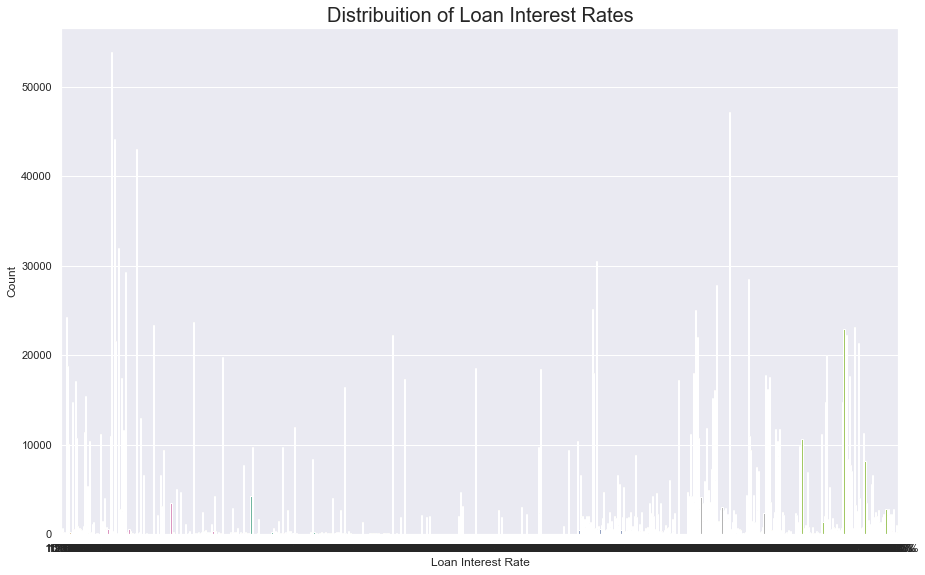

In [52]:
# Explore distrubution of loan interest rates
plt.figure(figsize = (15,12))
plt.subplot(211)
g1 = sns.countplot(x="int_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("Loan Interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Distribuition of Loan Interest Rates", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 1.2,top = 2)

plt.show()

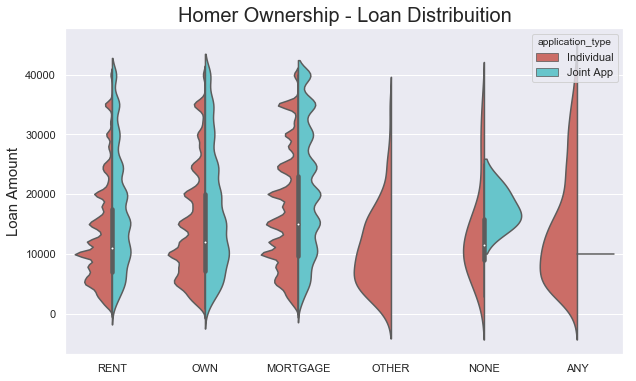

In [53]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

Purposes count description: 
application_type    Individual  Joint App
purpose                                  
car                      19829        566
credit_card             401026      12820
debt_consolidation     1031471      41847
educational                424          0
home_improvement        120451       4898
house                     9988        297
major_purchase           40716       1324
medical                  21452       1179
moving                   12570        463
other                   110453       3703
renewable_energy          1195         38
small_business           20836        616
vacation                 12469        304
wedding                   2354          1


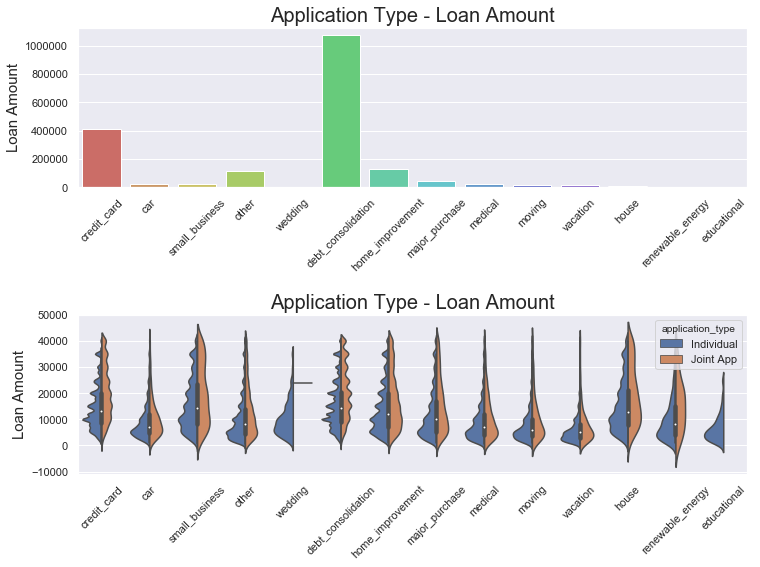

In [54]:
# Explore Loan Purpose
print("Purposes count description: ")
print(pd.crosstab(df.purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="purpose",y="loan_amnt",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

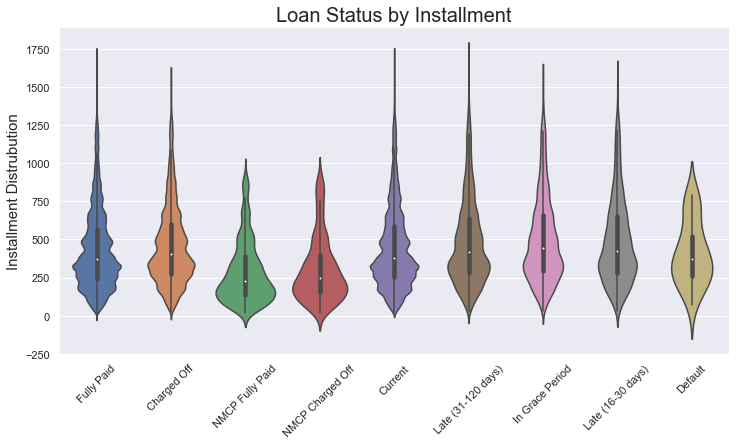

In [55]:
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'NMCP Fully Paid'
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'NMCP Charged Off'

plt.figure(figsize = (12,6))

g = sns.violinplot(x='loan_status', y="installment",
                   data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Installment Distrubution", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

Current               812194
Fully Paid            811895
Charged Off           208657
Late (31-120 days)     19535
In Grace Period        13634
Late (16-30 days)       4602
NMCP Fully Paid         1988
NMCP Charged Off         761
Default                   24
Name: loan_status, dtype: int64


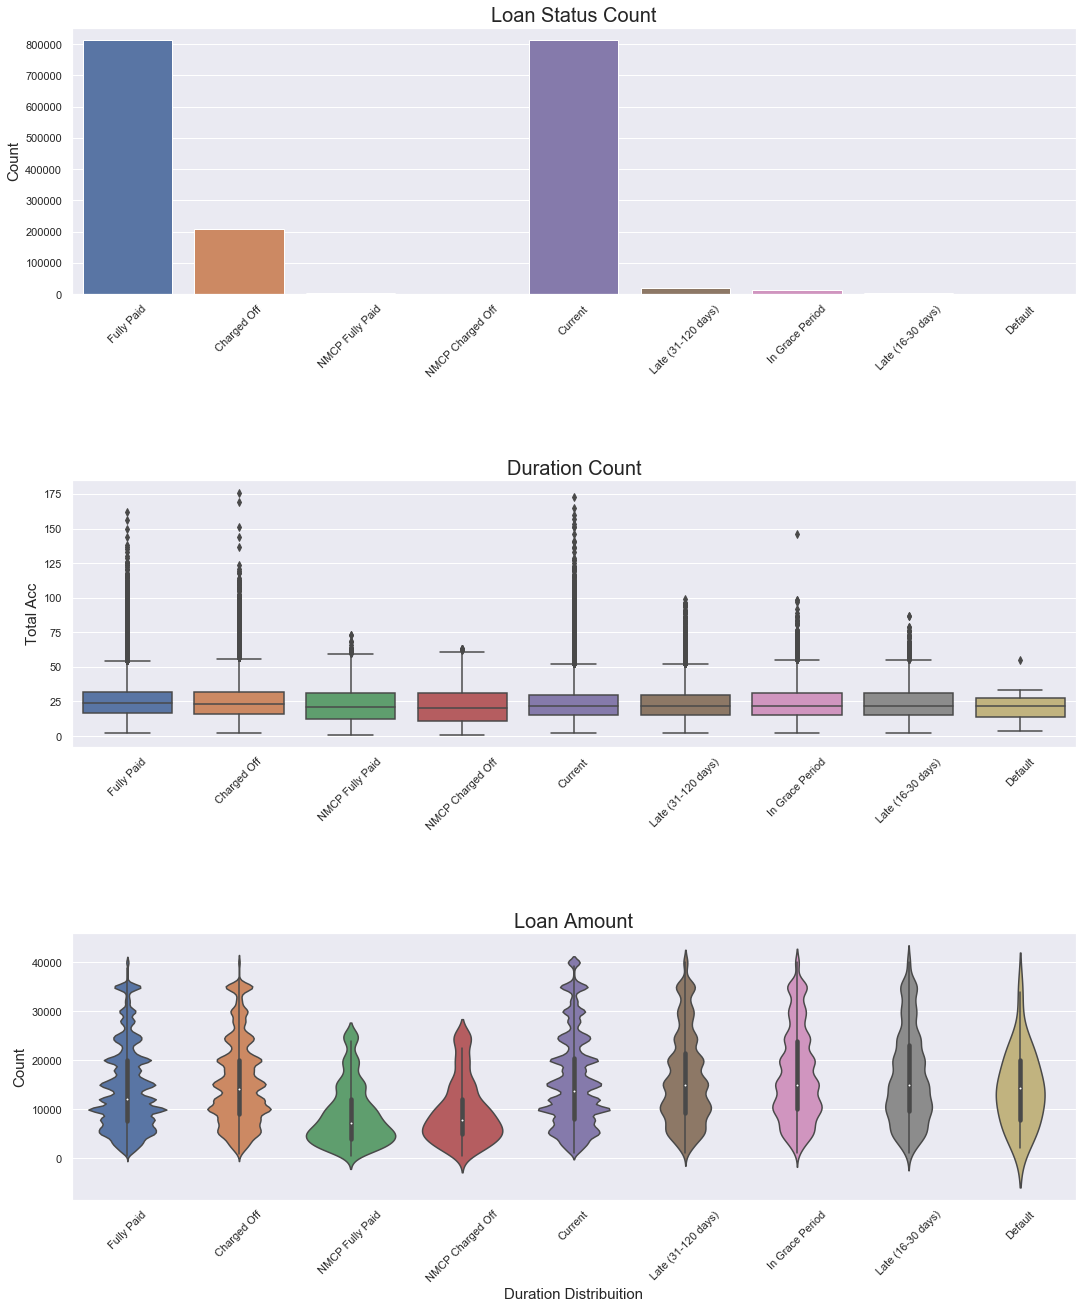

In [56]:
print(df.loan_status.value_counts())

plt.figure(figsize = (18,21))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="total_acc", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Total Acc", fontsize=15)
g1.set_title("Duration Count", fontsize=20)

plt.subplot(313)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()